# Remote Timing Attacks are Practical
_Experiment 6: Investigation of measurements taken from within the OpenSSL library, and how they compare to network timings._

---

In [1]:
import scipy
import scipy.signal
import seaborn
import sympy
import numpy
import pandas
import os
import matplotlib.pyplot as plt

from IPython import display
from pprint import pprint

In [2]:
import tls
import attack

In [3]:
q = sympy.Integer(11353860437120204348539420361367294927683441924641720282978666316144621735920188475867378638813811676070362003602263559496393696538309271007870774914687283)
p = sympy.Integer(11693128827090800677443535237632476895247105886644942164014088484470194179491435241190389270827811769965853291192455791684691555403909415703633832493911789)
N = sympy.Integer(132762152776056020551326919245624484615462467876809681535549565118332290525598572815747323476102181376625279228965473106140757139049665124368186142774966643990206422037551427526013151129106319233128471783533673959766053786798472937188481868923726256436384468384858420931063093337134977283618537887974322079287)

q_bits = attack.sympy_integer_to_bits(q)
p_bits = attack.sympy_integer_to_bits(p)
N_bits = attack.sympy_integer_to_bits(N)

In [8]:
NEIGHBOURHOOD_SIZE = 400
SAMPLE_SIZE = 10
BRUTEFORCED_BITS = 4
BITS_TO_RECOVER = 30

In [9]:
%matplotlib notebook
PLOT_KWARGS = {
    "height": 4.5, 
    "aspect": 16/8, 
}

The internal measurements are taken by `printf`ing the cycle count before and after the `RSA_private_decrypt` call in `ssl3_get_client_key_exchange()`. We use the same method to count cycles as in the network measurements. The changes can be seen below (sourced from `server/djwj-openssl-patch`):

```diff
diff -ruN orig/ssl/s3_srvr.c new/ssl/s3_srvr.c
--- orig/ssl/s3_srvr.c	2002-11-29 11:31:51.000000000 +0000
+++ new/ssl/s3_srvr.c	2020-02-13 10:55:33.088817021 +0000
@@ -125,6 +125,7 @@
 #include <openssl/md5.h>
 #include "cryptlib.h"
 
+
 static SSL_METHOD *ssl3_get_server_method(int ver);
 static int ssl3_get_client_hello(SSL *s);
 static int ssl3_check_client_hello(SSL *s);
@@ -1362,6 +1363,8 @@
 
 static int ssl3_get_client_key_exchange(SSL *s)
 	{
+        printf("djwj: Processing Client Key Exchange message.\n");
+
 	int i,al,ok;
 	long n;
 	unsigned long l;
@@ -1440,7 +1443,34 @@
 				n=i;
 			}
 
+		// djwj: start
+		unsigned start_cycles_high, start_cycles_low;
+		unsigned end_cycles_high, end_cycles_low;
+
+		asm volatile (
+			"CPUID;"
+			"RDTSC;"
+			"mov %%edx, %0;"
+			"mov %%eax, %1;"
+			: "=r" (start_cycles_high), "=r" (start_cycles_low)
+			:
+			: "%rax", "%rbx", "%rcx", "%rdx"
+		);
 		i=RSA_private_decrypt((int)n,p,p,rsa,RSA_PKCS1_PADDING);
+		asm volatile(
+			"RDTSCP;"
+			"mov %%edx, %0;"
+			"mov %%eax, %1;"
+			"CPUID;"
+			: "=r" (end_cycles_high), "=r" (end_cycles_low)
+			:
+			: "%rax", "%rbx", "%rcx", "%rdx"
+		);
+		unsigned long long start = ((unsigned long long)start_cycles_high << 32) | start_cycles_low;
+		unsigned long long end = ((unsigned long long)end_cycles_high << 32) | end_cycles_low;
+
+		printf("djwj: internal measurement: time=%llu, p(hex)=", end-start); int dani; for (dani = 0; dani < (int)n; dani++) {printf("%02X", p[dani]);} printf("\n");
+		// djwj: end
 
 		al = -1;
 		
@@ -1481,6 +1511,7 @@
 			 * "Chosen Ciphertext Attacks Against Protocols Based on the RSA
 			 * Encryption Standard PKCS #1", CRYPTO '98, LNCS 1462, pp. 1-12).
 			 */
+                        printf("djwj: Decryption failed of Pre-Master Secret from Client Key Exchange message. Replacing with random bytes instead. \n");
 			ERR_clear_error();
 			i = SSL_MAX_MASTER_KEY_LENGTH;
 			p[0] = s->client_version >> 8;
@@ -1494,6 +1525,10 @@
 				s->session->master_key,
 				p,i);
 		OPENSSL_cleanse(p,i);
+
+                printf("djwj: Derived master key ");
+		int i; for (i = 0; i < s->session->master_key_length; i++) {printf("%02X", s->session->master_key[i]);} printf(".\n");
+
 		}
 	else
 #endif
@@ -1727,6 +1762,7 @@
 
 	return(1);
 f_err:
+        printf("djwj: Sending Alert (level=Fatal) message. \n");
 	ssl3_send_alert(s,SSL3_AL_FATAL,al);
 #if !defined(OPENSSL_NO_DH) || !defined(OPENSSL_NO_RSA)
 err:
@@ -2054,3 +2090,4 @@
 	/* SSL3_ST_SW_CERT_B */
 	return(ssl3_do_write(s,SSL3_RT_HANDSHAKE));
 	}
+
```

The servers log files are then `grep`'d for the appropriate string, and saved to the `./measurements/internal-measurements.txt` file via the following command:

```sh
docker-compose logs --no-color --follow --tail=all server \
    | grep "djwj: internal measurement: " \
    > ./client/measurements/internal-measurements.txt
```

We'll load that in now for analysis. There's quite a lot of string processing to do per-line, so this might take a while. 

In [10]:
filename = "./measurements/internal-measurements.txt"

measurements = {
    'u_g': [],
    'time': [],
}

with open(filename, 'r') as file:
    for line in file:
        # Format: "<server_name>  | djwj: internal measurement: time=<time-in-cycles>, p(hex)=<point>\n"
        line = line.strip("\n\t ").replace("server_1  | djwj: internal measurement: time=", "")
        time_str, point_str = line.split(", p(hex)=")
        
        time = int(time_str)
        point = attack.bytes_to_sympy_integer(bytes.fromhex(point_str))
        
        measurements['time'].append(time)
        measurements['u_g'].append(point)
        
measurements = pandas.DataFrame(measurements)

In [11]:
measurements

,u_g,time
0,6001451062796899855966367813708300813734141704...,6031228
1,6001451062796899855966367813708300813734141704...,6927870
2,6001451062796899855966367813708300813734141704...,5518607
3,6001451062796899855966367813708300813734141704...,6407515
4,6001451062796899855966367813708300813734141704...,6614978
...,...,...
271980,2689016413973198354065476563422551284014815979...,6037080
271981,2689016413973198354065476563422551284014815979...,6042523
271982,2689016413973198354065476563422551284014815979...,6939046
271983,2689016413973198354065476563422551284014815979...,7241478


Convert the `u_g` values that the server received back into `point`s by reversing the trasnform in `attack.reverse_montegomery_transform`:

In [12]:
R = attack.calc_montgomery_R(N)

def montgomery_transform(u_g):
    return (u_g * R) % N

measurements['point'] = measurements['u_g'].apply(montgomery_transform)

del measurements['u_g']

In [13]:
bruteforce_samples = measurements[0:32000]
bit_samples = measurements[32000:]

In [14]:
bruteforce_samples

,time,point
0,6031228,6703903964971298549787012499102923063739682910...
1,6927870,6703903964971298549787012499102923063739682910...
2,5518607,6703903964971298549787012499102923063739682910...
3,6407515,6703903964971298549787012499102923063739682910...
4,6614978,6703903964971298549787012499102923063739682910...
...,...,...
31995,6032301,1256981993432118478085064843581798074451190545...
31996,5499657,1256981993432118478085064843581798074451190545...
31997,6547792,1256981993432118478085064843581798074451190545...
31998,7428522,1256981993432118478085064843581798074451190545...


Now we repeat the analysis in the [attack notebook](attack.ipynb##Bruteforce-Top-Few-Bits-of-$q$) for bruteforcing the top bits of $q$:

In [15]:
# Take median from each sample set
bruteforce_samples = bruteforce_samples.groupby(by="point").median().reset_index()

# Group into neighbourhoods
def point_to_neighbourhood(point):
    point_int = sympy.Integer(point)
    point_bits = attack.sympy_integer_to_bits(point_int)
    neighbourhood_point_bits = point_bits[0:BRUTEFORCED_BITS] + [0] * (512-BRUTEFORCED_BITS)
    neighbourhood_point_int = attack.bits_to_sympy_integer(neighbourhood_point_bits)
    return neighbourhood_point_int

bruteforce_samples['neighbourhood'] = bruteforce_samples['point'].apply(point_to_neighbourhood)

# Take the sum of neighbour medians in each neighbourhood
bruteforce_samples = bruteforce_samples.groupby(by="neighbourhood").sum().reset_index()

In [16]:
sqrt_N = sympy.sqrt(N)

bruteforce_samples['point_relative_to_sqrt_n'] = bruteforce_samples['neighbourhood'].apply(lambda g: round(float(g/sqrt_N), 10))

q_relative_to_sqrt_n = round(float(q/sqrt_N), 10)
p_relative_to_sqrt_n = round(float(p/sqrt_N), 10)

In [17]:
smallest_time_observed = bruteforce_samples['time'].min()
largest_time_observed = bruteforce_samples['time'].max()

buffer = (largest_time_observed - smallest_time_observed)/10

smallest_time_observed, largest_time_observed, buffer

(2521467397.0, 2578244216.0, 5677681.9)

In [18]:
ylim = (
    smallest_time_observed - buffer,
    largest_time_observed + buffer,
)

<IPython.core.display.Javascript object>


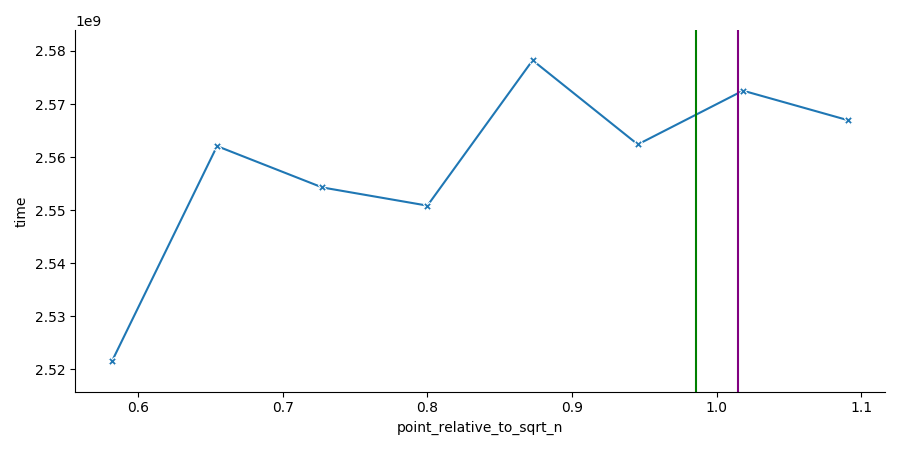

In [19]:
g = seaborn.relplot(data=bruteforce_samples, x='point_relative_to_sqrt_n', y='time', kind='line', marker="X", **PLOT_KWARGS)
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')
g.set(ylim=ylim)
g

Find peaks and plot them:

In [20]:
peak_indices, _ = scipy.signal.find_peaks(bruteforce_samples['time'])
len(peak_indices)

3

<IPython.core.display.Javascript object>


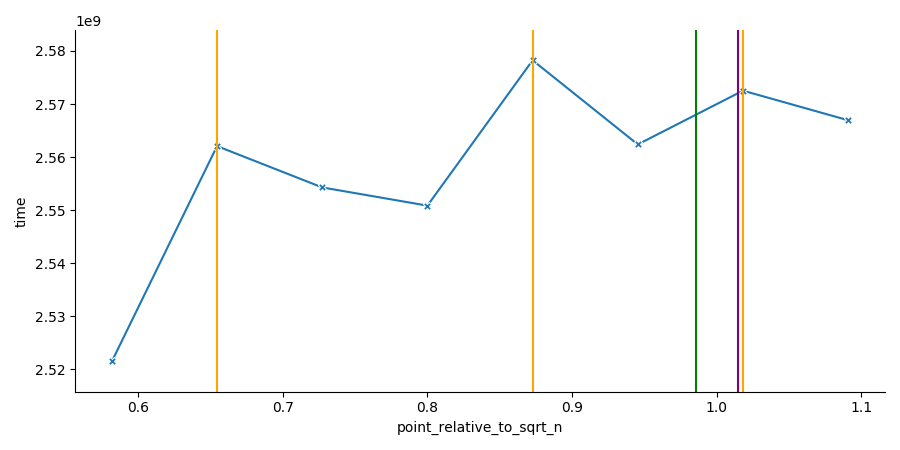

In [21]:
g = seaborn.relplot(data=bruteforce_samples, x='point_relative_to_sqrt_n', y='time', kind='line', marker="X", **PLOT_KWARGS)

plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')

for peak_index in peak_indices:
    peak = bruteforce_samples.iloc[peak_index]
    plt.plot([peak['point_relative_to_sqrt_n'], peak['point_relative_to_sqrt_n']], ylim, color='orange')

g.set(ylim=ylim)
g

Bound $q$ by peaks an $\sqrt{N}$:

In [22]:
for peak_index in peak_indices:
    peak_row = bruteforce_samples.iloc[peak_index]
    peak_g = peak_row['neighbourhood']
    
    if peak_g > sqrt_N:
        peak_index = previous_peak_index
        peak_row = bruteforce_samples.iloc[peak_index]
        peak_g = peak_row['neighbourhood']
        break
    
    previous_peak_index = peak_index
        
lower_bound = peak_g
upper_bound = sympy.Integer(sqrt_N.round())

<IPython.core.display.Javascript object>


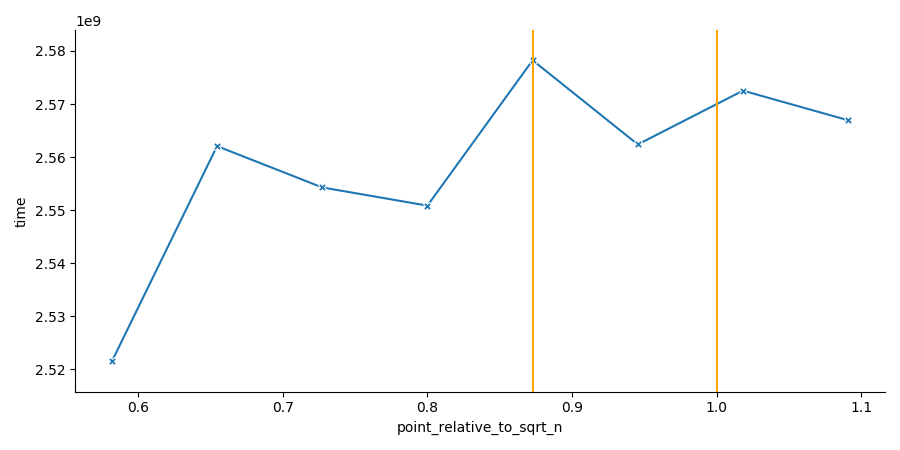

In [23]:
lower_bound_relative_to_sqrt_n = round(float(lower_bound/sqrt_N), 10)
upper_bound_relative_to_sqrt_n = round(float(upper_bound/sqrt_N), 10)

g = seaborn.relplot(data=bruteforce_samples, x='point_relative_to_sqrt_n', y='time', kind='line', marker="X", **PLOT_KWARGS)

plt.plot([lower_bound_relative_to_sqrt_n, lower_bound_relative_to_sqrt_n], ylim, color='orange')
plt.plot([upper_bound_relative_to_sqrt_n, upper_bound_relative_to_sqrt_n], ylim, color='orange')

g.set(ylim=ylim)
g

In [24]:
lower_bound_bits = attack.sympy_integer_to_bits(lower_bound)
upper_bound_bits = attack.sympy_integer_to_bits(upper_bound)

known_q_bits = []
for i in range(BRUTEFORCED_BITS):
    if lower_bound_bits[i] == upper_bound_bits[i]:
        known_q_bits.append(lower_bound_bits[i])
    else:
        break
        
known_q_bits

[1, 1, 0]

Similar results to those in `attack.ipynb` which used network measurements.

## Recovering Bits of $q$

We can reuse the code in the `attack.ipynb` notebook if we recover the `bit_position` and `bit_value` columns in this dataframe:

In [25]:
bit_samples = bit_samples.copy().reset_index()
del bit_samples['index']

bit_samples['bit_position'] = -1
bit_samples['bit_value'] = -1

for bit_position in range(BITS_TO_RECOVER):
    zero_start = 2*bit_position*SAMPLE_SIZE*NEIGHBOURHOOD_SIZE
    zero_end = one_start = (2*bit_position+1)*SAMPLE_SIZE*NEIGHBOURHOOD_SIZE
    one_end = (2*bit_position+2)*SAMPLE_SIZE*NEIGHBOURHOOD_SIZE

    bit_samples['bit_position'].iloc[zero_start:zero_end] = bit_position
    bit_samples['bit_value'].iloc[zero_start:zero_end] = 0
    
    bit_samples['bit_position'].iloc[one_start:one_end] = bit_position
    bit_samples['bit_value'].iloc[one_start:one_end] = 1
    
bit_samples

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,time,point,bit_position,bit_value
0,236932,0,0,0
1,252657,0,0,0
2,265824,0,0,0
3,259663,0,0,0
4,263982,0,0,0
...,...,...,...,...
239980,6037080,1135386042651796011496719461906206033578660488...,29,1
239981,6042523,1135386042651796011496719461906206033578660488...,29,1
239982,6939046,1135386042651796011496719461906206033578660488...,29,1
239983,7241478,1135386042651796011496719461906206033578660488...,29,1


In [26]:
bit_timings = bit_samples\
    .groupby(["bit_position", "bit_value", "point"]).median()\
    .groupby(["bit_position", "bit_value"]).sum()\
    .reset_index()

bit_timings

,bit_position,bit_value,time
0,0,0,2.546511e+09
1,0,1,2.564717e+09
2,1,0,2.552659e+09
3,1,1,2.550180e+09
4,2,0,2.557320e+09
5,2,1,2.549013e+09
6,3,0,2.564426e+09
7,3,1,2.556741e+09
8,4,0,2.544335e+09
9,4,1,2.553809e+09


In [27]:
def calc_zero_one_gap(row):
    T_g_low = row[row['bit_value']==0]['time'].iloc[0]
    T_g_high = row[row['bit_value']==1]['time'].iloc[0]
    return abs(T_g_low-T_g_high)

zero_one_gaps = bit_timings.groupby("bit_position").apply(calc_zero_one_gap)
zero_one_gaps

bit_position
0     18206420.0
1      2478839.0
2      8306755.5
3      7685200.5
4      9473858.5
5     14424628.5
6      3353935.0
7     11666485.5
8     18359661.0
9      7271074.5
10    11724984.0
11     3242856.5
12    27560042.5
13    14987572.5
14    10979747.0
15     1144041.0
16    16220357.5
17    11421021.5
18    22444293.5
19    30528609.5
20     5006235.5
21    41789907.0
22    19017100.5
23      341579.0
24    22777778.0
25    36471744.0
26     9658359.0
27    10726487.0
28    12661412.0
29     3637350.5
dtype: float64

<IPython.core.display.Javascript object>


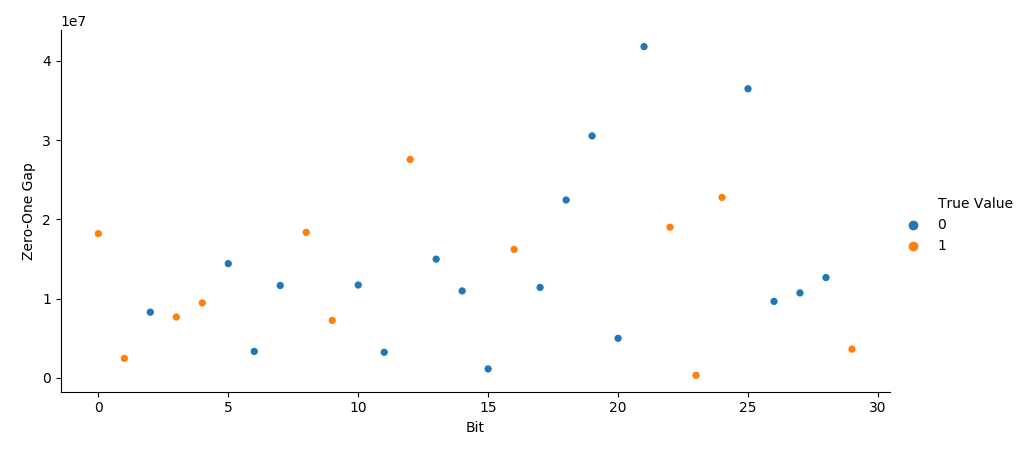

In [28]:
seaborn.relplot(
    data=pandas.DataFrame({
        'True Value': q_bits[0:BITS_TO_RECOVER],
        'Zero-One Gap': zero_one_gaps,
        'Bit': range(0, BITS_TO_RECOVER),
    }),
    x='Bit',
    y='Zero-One Gap',
    hue='True Value',
    kind='scatter',
    **PLOT_KWARGS,
)

These results are _very_ similar to the results in `attack.ipynb`, also indicating no meaningful difference in the time gaps between 0-bits and 1-bits.

In [29]:
def calc_point(row):
    bit_position, bit_value = int(row['bit_position']), int(row['bit_value'])
    point_bits = q_bits[0:bit_position] + [bit_value] + [0]*(len(q_bits) - 1 - bit_position)
    point = attack.bits_to_sympy_integer(point_bits)
    return point

bit_timings['neighbourhood'] = bit_timings.apply(calc_point, axis=1)
bit_timings = bit_timings.groupby('neighbourhood').mean()
bit_timings = bit_timings.reset_index()
bit_timings['point_relative_to_sqrt_n'] = bit_timings['neighbourhood'].apply(lambda g: round(float(g/sqrt_N), 10))

<IPython.core.display.Javascript object>


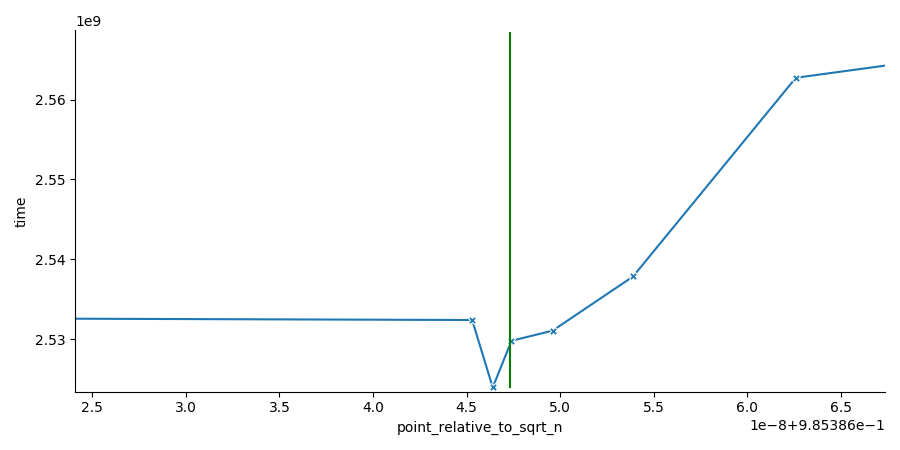

In [30]:
g = seaborn.relplot(
    data=bit_timings, 
    x='point_relative_to_sqrt_n', 
    y='time',
    kind='line', 
    marker="X",
    **PLOT_KWARGS,
)
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [bit_timings['time'].min(), bit_timings['time'].max()], color='green')
g